In [ ]:
pip install -U scikit-fuzzy

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from skfuzzy.cluster import cmeans
from sklearn.metrics import silhouette_score

## Defining the bucket 
s3 = boto3.resource('s3')
bucket_name = 'data-445'
bucket = s3.Bucket(bucket_name)

## Defining the csv file 
file_key = 'Fall_2021/In_Class_Assignments/customers.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
customers = pd.read_csv(file_content_stream)
customers.head()

,ID,Visit_Time,Average_Expense,Sex,Age
0,1,3,5.7,0,10
1,2,5,14.5,0,27
2,3,16,33.5,0,32
3,4,5,15.9,0,30
4,5,16,24.9,0,23


In [2]:
## Dropping ID 
customers = customers.drop(columns = 'ID', axis = 1)
customers.head()

,Visit_Time,Average_Expense,Sex,Age
0,3,5.7,0,10
1,5,14.5,0,27
2,16,33.5,0,32
3,5,15.9,0,30
4,16,24.9,0,23


In [3]:
## Transforming variables to 0-1 scale 
scaler = MinMaxScaler()

customers[['Visit_Time_0_1', 'Average_Expense_0_1', 'Age_0_1']] = scaler.fit_transform(customers[['Visit_Time', 'Average_Expense', 'Age']])
customers.head()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1
0,3,5.7,0,10,0.117647,0.041096,0.051282
1,5,14.5,0,27,0.235294,0.342466,0.487179
2,16,33.5,0,32,0.882353,0.993151,0.615385
3,5,15.9,0,30,0.235294,0.390411,0.564103
4,16,24.9,0,23,0.882353,0.698630,0.384615


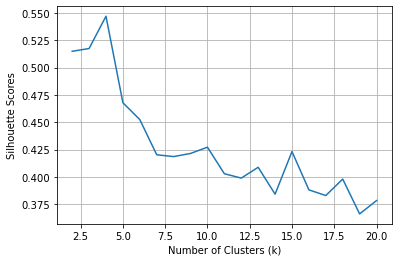

In [4]:
## Defining a list to store silhouette scores
results = list()

for i in range(2, 21):
    
    ## Clustering the data 
    kmeans_md = KMeans(n_clusters = i, n_init = 20).fit(customers[['Sex', 'Visit_Time_0_1', 'Average_Expense_0_1', 'Age_0_1']])
    kmeans_labels = kmeans_md.labels_
    
    ## Computing the silhouette score
    results.append(silhouette_score(customers[['Sex', 'Visit_Time_0_1', 'Average_Expense_0_1', 'Age_0_1']], kmeans_labels))
    
## Visualizing the silhouette scores
plt.plot(range(2, 21), results)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Scores')
plt.grid()
plt.show()

In [6]:
X = customers[['Sex', 'Visit_Time_0_1', 'Average_Expense_0_1', 'Age_0_1']]

## Clustering the data into 4 cluster using cmeans
fc, W, u0, d, jm, p, pc = cmeans(X.T, c = 4, m = 1.25, error = 1e-6, maxiter = 1000)

In [11]:
customers['cluster'] = np.nan
customers.head()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1,cluster
0,3,5.7,0,10,0.117647,0.041096,0.051282,NaN
1,5,14.5,0,27,0.235294,0.342466,0.487179,NaN
2,16,33.5,0,32,0.882353,0.993151,0.615385,NaN
3,5,15.9,0,30,0.235294,0.390411,0.564103,NaN
4,16,24.9,0,23,0.882353,0.698630,0.384615,NaN


In [14]:
customers['cluster'] = np.where(W[0] > 0.7, 1, customers['cluster'])
customers['cluster'] = np.where(W[1] > 0.7, 2, customers['cluster'])
customers['cluster'] = np.where(W[2] > 0.7, 3, customers['cluster'])
customers['cluster'] = np.where(W[3] > 0.7, 4, customers['cluster'])
customers.head()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1,cluster
0,3,5.7,0,10,0.117647,0.041096,0.051282,3.0
1,5,14.5,0,27,0.235294,0.342466,0.487179,3.0
2,16,33.5,0,32,0.882353,0.993151,0.615385,4.0
3,5,15.9,0,30,0.235294,0.390411,0.564103,3.0
4,16,24.9,0,23,0.882353,0.698630,0.384615,4.0


In [16]:
## Cluster 1
cluster_1 = customers[customers['cluster'] ==  1].reset_index(drop = True)
cluster_1.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1,cluster
count,16.000000,16.000000,16.0,16.000000,16.000000,16.000000,16.000000,16.0
mean,12.250000,25.362500,1.0,31.187500,0.661765,0.714469,0.594551,1.0
std,2.955221,4.336339,0.0,8.336416,0.173837,0.148505,0.213754,0.0
min,8.000000,17.800000,1.0,17.000000,0.411765,0.455479,0.230769,1.0
25%,10.000000,21.100000,1.0,26.000000,0.529412,0.568493,0.461538,1.0
50%,12.000000,25.450000,1.0,28.500000,0.647059,0.717466,0.525641,1.0
75%,13.250000,28.275000,1.0,36.750000,0.720588,0.814212,0.737179,1.0
max,18.000000,33.700000,1.0,47.000000,1.000000,1.000000,1.000000,1.0


In [17]:
## Cluster 2
cluster_2 = customers[customers['cluster'] ==  2].reset_index(drop = True)
cluster_2.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1,cluster
count,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.000000,24.0
mean,5.416667,10.591667,1.0,15.291667,0.259804,0.208619,0.186966,2.0
std,2.430185,4.474752,0.0,4.666990,0.142952,0.153245,0.119666,0.0
min,1.000000,4.500000,1.0,8.000000,0.000000,0.000000,0.000000,2.0
25%,3.000000,7.875000,1.0,11.750000,0.117647,0.115582,0.096154,2.0
50%,6.000000,10.900000,1.0,16.000000,0.294118,0.219178,0.205128,2.0
75%,7.000000,12.000000,1.0,17.500000,0.352941,0.256849,0.243590,2.0
max,10.000000,23.800000,1.0,23.000000,0.529412,0.660959,0.384615,2.0


In [18]:
## Cluster 3
cluster_3 = customers[customers['cluster'] ==  3].reset_index(drop = True)
cluster_3.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1,cluster
count,11.000000,11.000000,11.0,11.00000,11.000000,11.000000,11.000000,11.0
mean,4.909091,12.709091,0.0,17.00000,0.229947,0.281133,0.230769,3.0
std,1.700267,6.060108,0.0,6.78233,0.100016,0.207538,0.173906,0.0
min,3.000000,4.600000,0.0,9.00000,0.117647,0.003425,0.025641,3.0
25%,3.500000,7.150000,0.0,12.00000,0.147059,0.090753,0.102564,3.0
50%,5.000000,14.500000,0.0,16.00000,0.235294,0.342466,0.205128,3.0
75%,6.000000,16.000000,0.0,20.00000,0.294118,0.393836,0.307692,3.0
max,8.000000,23.800000,0.0,30.00000,0.411765,0.660959,0.564103,3.0


In [19]:
## Cluster 4
cluster_4 = customers[customers['cluster'] ==  4].reset_index(drop = True)
cluster_4.describe()

,Visit_Time,Average_Expense,Sex,Age,Visit_Time_0_1,Average_Expense_0_1,Age_0_1,cluster
count,8.000000,8.000000,8.0,8.000000,8.000000,8.000000,8.000000,8.0
mean,14.375000,25.587500,0.0,26.625000,0.786765,0.722175,0.477564,4.0
std,1.846812,4.647714,0.0,5.629958,0.108636,0.159168,0.144358,0.0
min,12.000000,18.800000,0.0,18.000000,0.647059,0.489726,0.256410,4.0
25%,13.500000,22.950000,0.0,22.750000,0.735294,0.631849,0.378205,4.0
50%,14.000000,25.400000,0.0,26.000000,0.764706,0.715753,0.461538,4.0
75%,16.000000,28.500000,0.0,32.250000,0.882353,0.821918,0.621795,4.0
max,17.000000,33.500000,0.0,33.000000,0.941176,0.993151,0.641026,4.0
